<a href="https://colab.research.google.com/github/jessicasilvacodes/dados-python-ufba/blob/main/projetofinal_ufba_JessicaSilva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUEIMADAS NO BRASIL EM 2024

Organização: Instituto Nacional de Pesquisas Espaciais (INPE)

Base de dados disponível nos sites [basedosdados.org](https://basedosdados.org/dataset/f06f3cdc-b539-409b-b311-1ff8878fb8d9?table=a3696dc2-4dd1-4f7e-9769-6aa16a1556b8) e [terrabrasilis.dpi.inpe.brk](https://terrabrasilis.dpi.inpe.br/queimadas/portal/dados-abertos/#da-focos)


Notebook e análises feitas por: [Jessica Santos da Silva](https://github.com/jessicasilvacodes)

### Projeto final do curso "Visualização de Dados em Python", do **Projeto Tomorrow**, pelo Instituto de Computação da Universidade Federal da Bahia (UFBA)

## INTRODUÇÃO:

As queimadas são focos de fogo detectados em áreas florestais, agrícolas ou urbanas, podendo ocorrer de forma natural ou podendo ser causada pelo ser humano. No Brasil, grande parte das queimadas é resultado de práticas agrícolas ilegais, como o desmatamento por corte e queima.

O monitoramento desses eventos é feito por satélites, e o Instituto Nacional de Pesquisas Espaciais (INPE) é o principal responsável por coletar, analisar e divulgar esses dados.

A análise desses dados é essencial para:

- Compreender a sazonalidade das queimadas;

- Avaliar os impactos ambientais e de saúde;

- Apoiar políticas públicas de preservação;

- Aumentar a conscientização sobre mudanças climáticas e uso do solo.

## IMPORTANDO BIBLIOTECAS:

In [47]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime
import folium
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## IMPORTANDO A BASE DE DADOS:

In [48]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projeto final - UFBA/focos_br_todos-sats_2024.csv')
df.head()

,latitude,longitude,data_pas,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,id_area_industrial,frp
0,4.27167,-60.69947,2024-01-02 02:06:00,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazônia,7.0,0.00,1.00,0,14.4
1,-9.55578,-35.70564,2024-01-02 04:08:00,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,0,0.4
2,-9.55515,-35.71013,2024-01-02 04:08:00,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,0,2.7
3,-7.36323,-39.94515,2024-01-02 04:08:00,NPP-375D,Brasil,PERNAMBUCO,BODOCÓ,Caatinga,7.0,1.32,0.54,0,2.1
4,-3.51178,-40.13655,2024-01-02 04:06:00,NPP-375D,Brasil,CEARÁ,SANTANA DO ACARAÚ,Caatinga,3.0,3.38,0.00,0,1.0


## LIMPEZA E PREPARAÇÃO DOS DADOS:

In [49]:
df.columns

Index(['latitude', 'longitude', 'data_pas', 'satelite', 'pais', 'estado',
       'municipio', 'bioma', 'numero_dias_sem_chuva', 'precipitacao',
       'risco_fogo', 'id_area_industrial', 'frp'],
      dtype='object')

Dividindo a coluna 'data_pas' e adicionando mais duas colunas, uma de data e uma de hora:

In [50]:
df['data_pas'] = pd.to_datetime(df['data_pas'])
df['data'] = df['data_pas'].dt.date
df['hora'] = df['data_pas'].dt.time

Criar uma coluna de 'ano' e 'mês':

In [51]:
df['data'] = pd.to_datetime(df['data'])
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

Limpando as colunas que não serão utilizadas:

In [52]:
df.drop(columns=['data_pas', 'id_area_industrial'], inplace=True)

Visualizando os dados:

In [53]:
df.head()

,latitude,longitude,satelite,pais,estado,municipio,bioma,numero_dias_sem_chuva,precipitacao,risco_fogo,frp,data,hora,ano,mes
0,4.27167,-60.69947,TERRA_M-M,Brasil,RORAIMA,PACARAIMA,Amazônia,7.0,0.00,1.00,14.4,2024-01-02,02:06:00,2024,1
1,-9.55578,-35.70564,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,0.4,2024-01-02,04:08:00,2024,1
2,-9.55515,-35.71013,NPP-375D,Brasil,ALAGOAS,MACEIÓ,Mata Atlântica,-999.0,0.00,1.00,2.7,2024-01-02,04:08:00,2024,1
3,-7.36323,-39.94515,NPP-375D,Brasil,PERNAMBUCO,BODOCÓ,Caatinga,7.0,1.32,0.54,2.1,2024-01-02,04:08:00,2024,1
4,-3.51178,-40.13655,NPP-375D,Brasil,CEARÁ,SANTANA DO ACARAÚ,Caatinga,3.0,3.38,0.00,1.0,2024-01-02,04:06:00,2024,1


In [54]:
df.shape

(8144823, 15)

Verificando valores nulos:

In [55]:
print(df.isnull().sum())

latitude                      0
longitude                     0
satelite                      0
pais                          0
estado                        0
municipio                     0
bioma                         1
numero_dias_sem_chuva     11219
precipitacao              11219
risco_fogo                11219
frp                      336392
data                          0
hora                          0
ano                           0
mes                           0
dtype: int64


Verificando valores duplicados:

In [56]:
print(df.duplicated().sum())

0


## ENTENDENDO OS DADOS:

| Coluna                  | Descrição                                                                                                         |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------- |
| `data`                  | data da detecção do foco de calor    
| `hora`                  | hora da detecção do foco de calor          
| `mês`                  | mês do registro
| `ano`                  | ano do registro                                                                          |
| `bioma`                 | bioma em que o foco ocorreu                                       |
| `estado`                | sigla do estado brasileiro                                                             |
| `municipio`             | município correspondente                                 |
| `satélite`              | nome do satélite que detectou o foco                                                                              |
| `frp`                   | **fire radiative power** = potência radiativa do fogo, em megawatts (MW) – representa a intensidade do foco |
| `numero_dias_sem_chuva`            | número de dias sem chuva na região antes da detecção                                                              |
| `precipitacao`          | precipitação de chuva acumulada no dia, em mm                                                                      |
| `risco_fogo`            | classificação do risco de fogo no momento (baixo, moderado, alto, crítico)                                        |
| `latitude`, `longitude` | coordenadas geográficas do ponto de foco                                                                          |
| `pais`                  | país (Brasil)                                                                                         |


## ANÁLISE EXPLORATÓRIA DOS DADOS E VISUALIZAÇÃO DE GRÁFICOS:

### Focos de queimada por mês:

In [57]:
focos_por_mes = df.groupby('mes').size().reset_index(name='total_focos')
focos_por_mes

,mes,total_focos
0,1,152585
1,2,156857
2,3,118873
3,4,49823
4,5,152051
5,6,353043
6,7,504158
7,8,2263154
8,9,2567880
9,10,1006520


In [58]:
fig = px.line(focos_por_mes, x='mes', y='total_focos', color_discrete_sequence=["orange"])
fig.show()

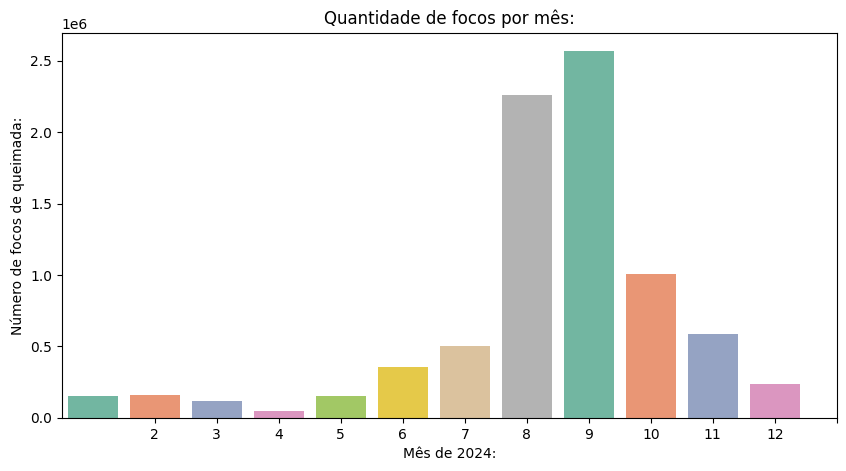

In [59]:
plt.figure(figsize=(10, 5))
sns.barplot(x='mes', y='total_focos', data=focos_por_mes, palette="Set2", hue='mes', legend=False)
plt.title('Quantidade de focos por mês:')
plt.xlabel('Mês de 2024:')
plt.ylabel('Número de focos de queimada:')
plt.xticks(range(1, 13)) #12 meses
plt.show()

### Focos de queimada por estado do Brasil:

In [60]:
focos_por_estado = df.groupby('estado').size().reset_index(name='total_focos')
focos_por_estado

,estado,total_focos
0,ACRE,139579
1,ALAGOAS,13571
2,AMAPÁ,41778
3,AMAZONAS,776216
4,BAHIA,224936
5,CEARÁ,81957
6,DISTRITO FEDERAL,6190
7,ESPÍRITO SANTO,15095
8,GOIÁS,150055
9,MARANHÃO,587909


Em ordem decrescente...

In [61]:
focos_por_estado = focos_por_estado.sort_values(by='total_focos', ascending=False)
focos_por_estado.head(10)

,estado,total_focos
15,PARÁ,1824366
10,MATO GROSSO,1737633
3,AMAZONAS,776216
9,MARANHÃO,587909
26,TOCANTINS,522645
11,MATO GROSSO DO SUL,464014
21,RONDÔNIA,366792
17,PIAUÍ,274523
12,MINAS GERAIS,266086
22,RORAIMA,251293


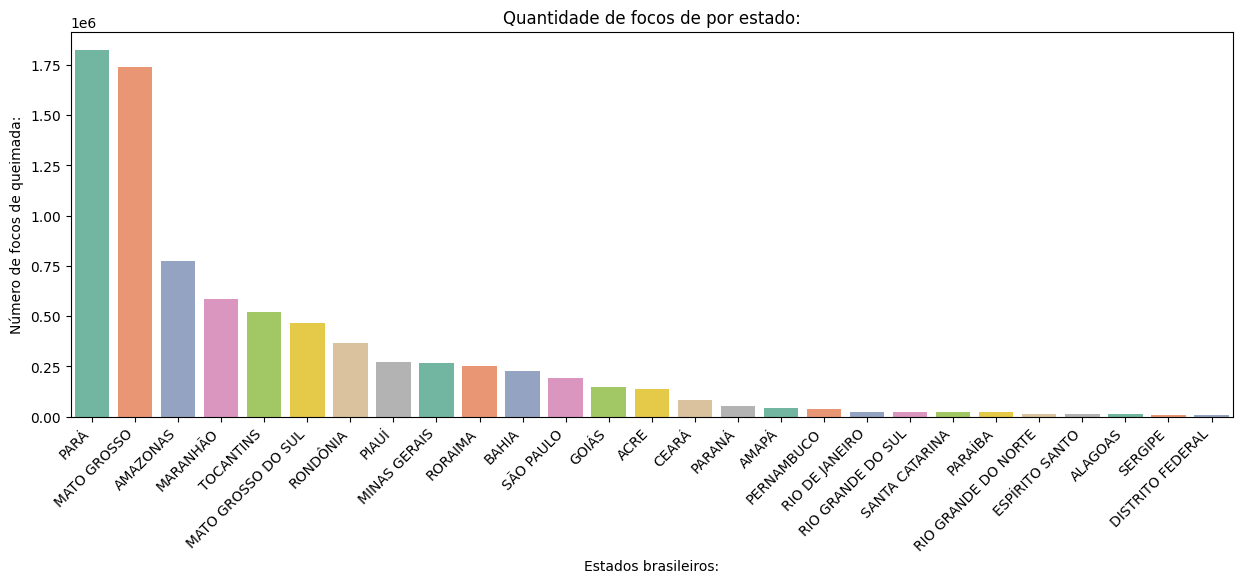

In [62]:
plt.figure(figsize=(15, 5))
sns.barplot(x='estado', y='total_focos', data=focos_por_estado, palette="Set2", hue='estado', legend=False)
plt.title('Quantidade de focos de por estado:')
plt.xlabel('Estados brasileiros:')
plt.ylabel('Número de focos de queimada:')
plt.xticks(rotation=45, ha='right')
plt.show()

### Focos de queimada por bioma brasileiro:

Em ordem decrescente...

In [63]:
focos_por_bioma = df.groupby('bioma').size().reset_index(name='total_focos')
focos_por_bioma = focos_por_bioma.sort_values(by='total_focos', ascending=False)
focos_por_bioma

,bioma,total_focos
0,Amazônia,4428932
2,Cerrado,2302100
5,Pantanal,603965
3,Mata Atlântica,437445
1,Caatinga,365807
4,Pampa,6573


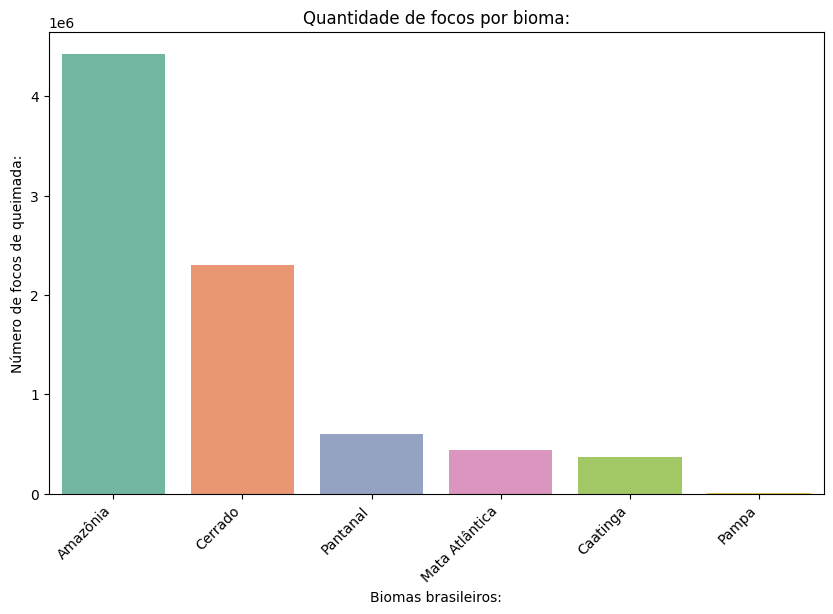

In [64]:
plt.figure(figsize=(10, 6))
sns.barplot(x='bioma', y='total_focos', data=focos_por_bioma, palette="Set2", hue='bioma', legend=False)
plt.title('Quantidade de focos por bioma:')
plt.xlabel('Biomas brasileiros:')
plt.ylabel('Número de focos de queimada:')
plt.xticks(rotation=45, ha='right')
plt.show()

In [65]:
focos_por_mes_bioma = df.groupby(['mes', 'bioma']).size().reset_index(name='total_focos')
focos_por_mes_bioma

,mes,bioma,total_focos
0,1,Amazônia,61127
1,1,Caatinga,20811
2,1,Cerrado,22166
3,1,Mata Atlântica,13692
4,1,Pampa,241
...,...,...,...
67,12,Caatinga,59722
68,12,Cerrado,42447
69,12,Mata Atlântica,13013
70,12,Pampa,418


### Bioma vs. Meses do ano:

Comparando a quantidade de focos de queimada por bioma ao longo dos meses de 2024:

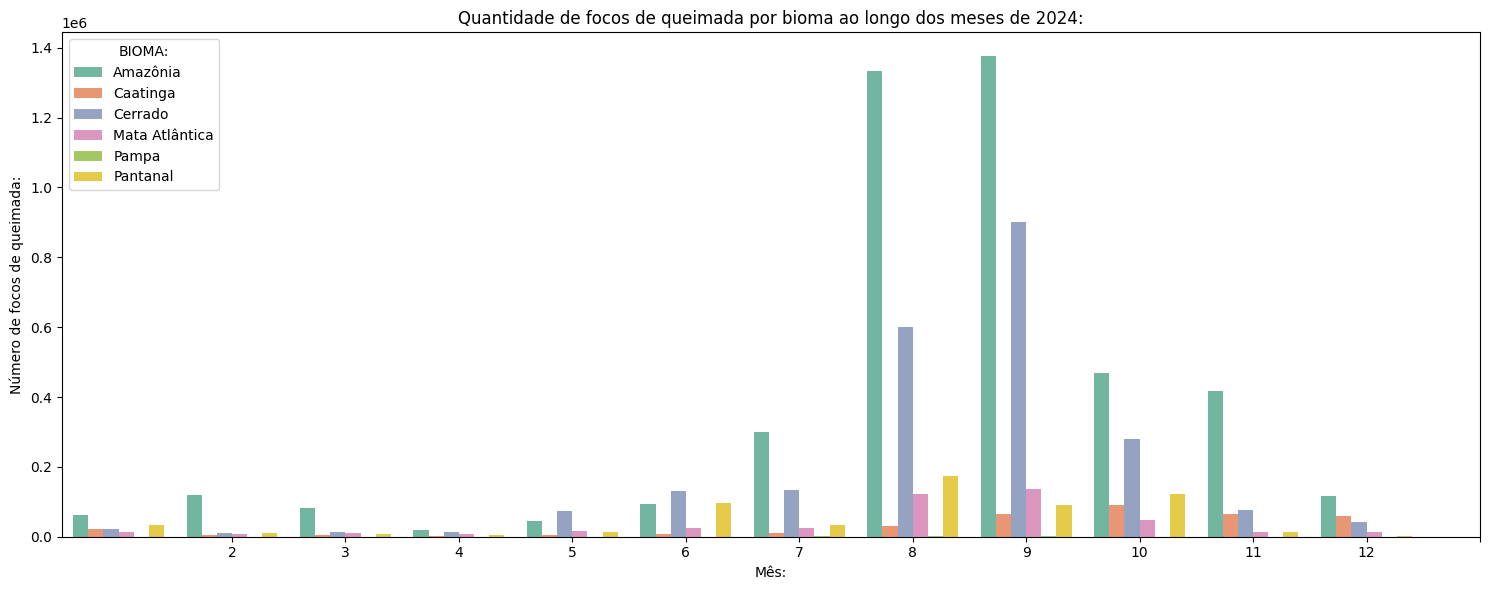

In [66]:
plt.figure(figsize=(15, 6))
sns.barplot(x='mes', y='total_focos', hue='bioma', data=focos_por_mes_bioma, palette="Set2")
plt.title('Quantidade de focos de queimada por bioma ao longo dos meses de 2024:')
plt.xlabel('Mês:')
plt.ylabel('Número de focos de queimada:')
plt.xticks(range(1, 13))  #12 meses
plt.legend(title='BIOMA:', loc='upper left')
plt.tight_layout()
plt.show()

### Mapa:

Analisando alguns exemplos de onde ocorreram os focos de queimada registrados no ano de 2024:

In [67]:
mapa = folium.Map(location=[-10, -52], zoom_start=5)

for i in range(0, 1000): #limite de mil focos de queimada
    folium.CircleMarker(
        location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
        radius=2,
        color='orange',
        fill=True
    ).add_to(mapa)
mapa

O mapa anterior mostra a localização geográfica de 1000 focos de queimadas no Brasil, utilizando latitude e longitude. Ele analisa a distribuição espacial desses focos no território brasileiro.  Cada círculo no mapa representa um foco, e sua posição indica a localização da queimada.

### Estados por bioma brasileiro:

In [68]:
estado_bioma = df.groupby(['estado', 'bioma']).size().reset_index(name='counts').sort_values('bioma', ascending=False)
estado_bioma

,estado,bioma,counts
21,MATO GROSSO DO SUL,Pantanal,313571
18,MATO GROSSO,Pantanal,290394
44,SANTA CATARINA,Pampa,2
39,RIO GRANDE DO SUL,Pampa,6571
12,GOIÁS,Mata Atlântica,5484
24,MINAS GERAIS,Mata Atlântica,118190
28,PARAÍBA,Mata Atlântica,4251
20,MATO GROSSO DO SUL,Mata Atlântica,37122
32,PERNAMBUCO,Mata Atlântica,9045
35,RIO DE JANEIRO,Mata Atlântica,25087


In [69]:
fig = px.treemap(estado_bioma, path=['bioma', 'estado'], values='counts',
                  color='bioma', hover_data=['estado', 'counts'])
fig.update_layout(title='Distribuição de estados por bioma:')
fig.show()

### Amostra de foco de queimadas no Brasil por bioma:

In [70]:
fig = px.scatter_geo(df.sample(1000), lat='latitude', lon='longitude',
                     color='bioma', hover_name='estado',
                     title='Amostra de focos de queimadas no Brasil:',
                     opacity=1)
fig.show()

### Analisando a distribuição da intensidade do foco (**frp**):

Correlação entre intensidade do foco de queimada e bioma:

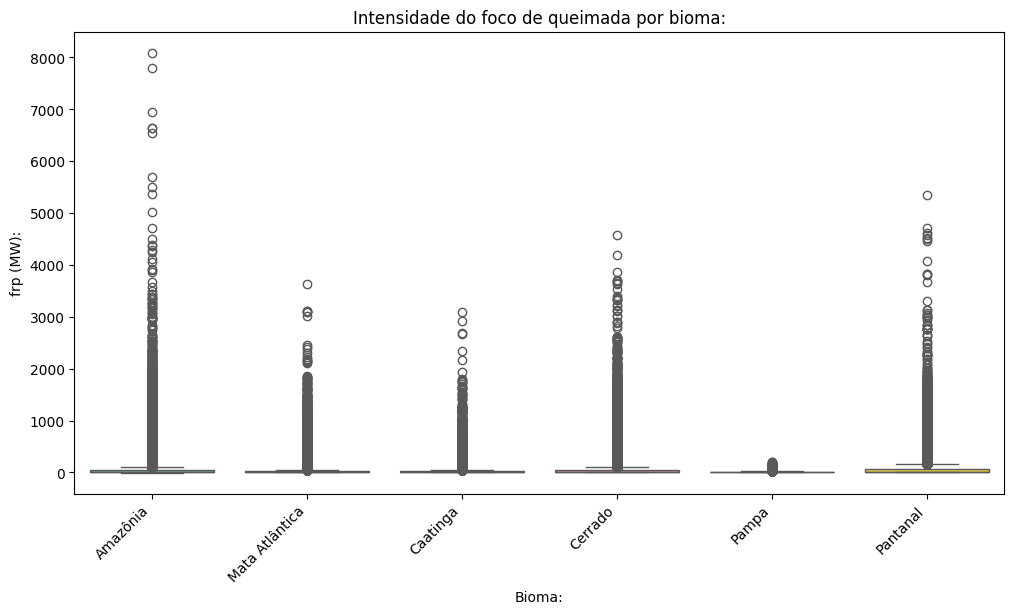

In [71]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bioma', y='frp', data=df, hue='bioma', legend=False, palette="Set2")
plt.title('Intensidade do foco de queimada por bioma:')
plt.xlabel('Bioma:')
plt.ylabel('frp (MW):')
plt.xticks(rotation=45, ha='right')
plt.show()

A comparação dos boxplots e dos _outliers_ permite analisar como a intensidade das queimadas varia entre os biomas.  Biomas com _outliers_ mais elevados tendem a apresentar focos de queimadas mais intensos.  Biomas sem _outliers_ extremos tendem a ter focos menos intensos.

## ANÁLISES DE CORRELAÇÃO:

In [72]:
df.columns

Index(['latitude', 'longitude', 'satelite', 'pais', 'estado', 'municipio',
       'bioma', 'numero_dias_sem_chuva', 'precipitacao', 'risco_fogo', 'frp',
       'data', 'hora', 'ano', 'mes'],
      dtype='object')

In [73]:
colunas_numericas = ['frp', 'risco_fogo', 'precipitacao', 'numero_dias_sem_chuva']

In [74]:
correlacao = df[colunas_numericas].corr()
correlacao

,frp,risco_fogo,precipitacao,numero_dias_sem_chuva
frp,1.000000,0.005241,-0.029274,0.034594
risco_fogo,0.005241,1.000000,-0.020326,0.039740
precipitacao,-0.029274,-0.020326,1.000000,-0.046525
numero_dias_sem_chuva,0.034594,0.039740,-0.046525,1.000000


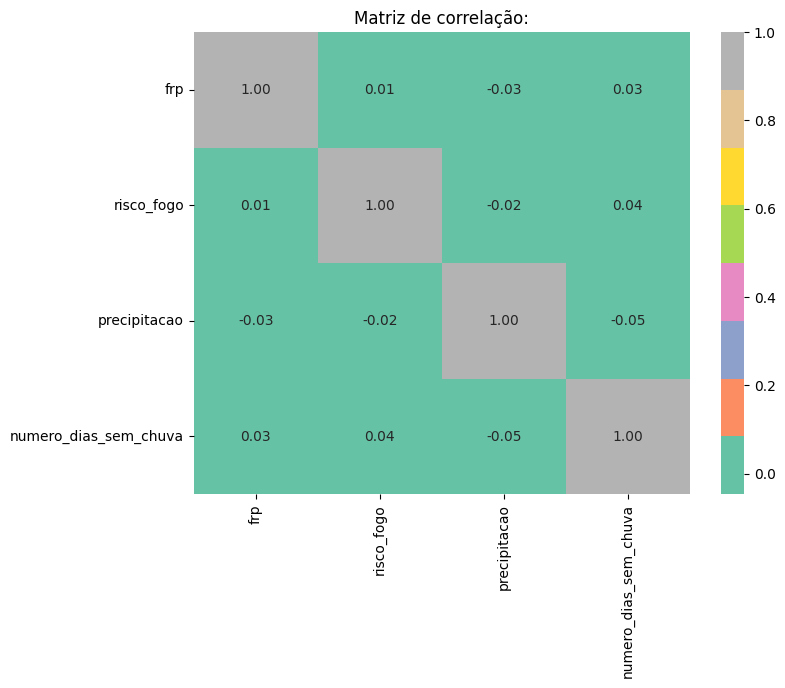

In [75]:
plt.figure(figsize=(8,6))
sns.heatmap(correlacao, annot=True, cmap='Set2', fmt='.2f')
plt.title('Matriz de correlação:')
plt.show()

A matriz de correlação mostra uma **correlação positiva** entre frp (potência do fogo) e risco de fogo, indicando que quanto maior o risco, maior tende a ser a intensidade dos focos. Também é visível uma **correlação negativa** entre risco de fogo e precipitação, o que é esperado, já que menos chuvas aumentam o risco de queimadas.


## ANÁLISE DE PREVISIBILIDADE:

### Risco de fogo vs. Precipitação:

Será que a precipitação (chuva) influencia o risco de fogo?

**Hipótese:** quanto menor a precipitação, maior o risco de fogo.

Filtrando os dados sem os valores nulos:

In [76]:
df_reg = df[['precipitacao', 'risco_fogo']].dropna()
print(df_reg.head())

   precipitacao  risco_fogo
0          0.00        1.00
1          0.00        1.00
2          0.00        1.00
3          1.32        0.54
4          3.38        0.00


Filtrando os dados sem os valores negativos:

In [77]:
df_filtered = df_reg[(df_reg['precipitacao'] >= 0) & (df_reg['risco_fogo'] >= 0)]
print(df_filtered.head())

   precipitacao  risco_fogo
0          0.00        1.00
1          0.00        1.00
2          0.00        1.00
3          1.32        0.54
4          3.38        0.00


Separando: X = precipitação, e y = risco de fogo.

In [78]:
X = df_reg['precipitacao'].values.reshape(-1, 1)
y = df_reg['risco_fogo'].values.reshape(-1, 1)

Criando o modelo de regressão linear:

In [79]:
modelo = LinearRegression()
modelo.fit(X, y)

LinearRegression()

Fazendo previsões:

In [80]:
y_pred = modelo.predict(X)

In [81]:
a = modelo.coef_[0][0]
b = modelo.intercept_[0]
r2 = r2_score(y, y_pred)

Visualizando...

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



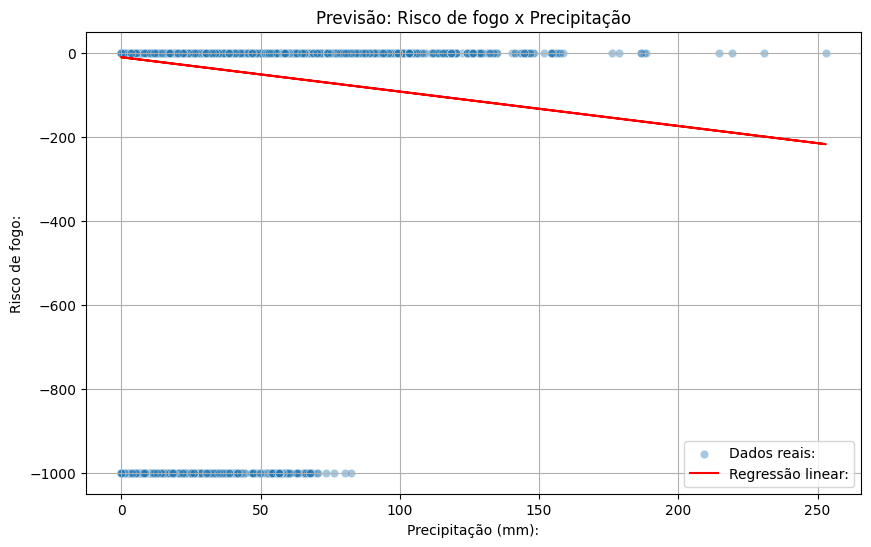

In [82]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_reg['precipitacao'], y=df_reg['risco_fogo'], alpha=0.4, label='Dados reais:')
plt.plot(df_reg['precipitacao'], y_pred, color='red', label='Regressão linear:')
plt.title('Previsão: Risco de fogo x Precipitação')
plt.xlabel('Precipitação (mm):')
plt.ylabel('Risco de fogo:')
plt.legend()
plt.grid(True)

O gráfico acima mostra uma análise de regressão linear entre a Precipitação (chuva) e o Risco de fogo.

*   **Pontos Azuis:** Representam os dados reais observados. Cada ponto é um par de valores, onde o eixo X mostra a quantidade de Precipitação em mm e o eixo Y mostra o valor do Risco de fogo. A dispersão dos pontos sugere que, em geral, quando a precipitação é baixa (à esquerda do gráfico), o risco de fogo tende a ser maior (mais para cima no gráfico).

*   **Linha Vermelha:** Esta é a linha de regressão linear. Ela representa a melhor reta que se ajusta aos dados reais. Esta linha tenta capturar a tendência geral da relação entre Precipitação e Risco de fogo.

A linha vermelha descendente indica que, de acordo com o modelo de regressão linear, existe uma relação negativa entre Precipitação e Risco de fogo, ou seja, à medida que a quantidade de chuva aumenta, o modelo prevê que o risco de fogo diminui.

Apesar da linha mostrar uma tendência, a dispersão dos pontos azuis em torno dela indica que a relação não é perfeitamente linear e outros fatores além da precipitação também influenciam o risco de fogo, como temperatura, vento e atividade humana.

## CONCLUSÃO:

A análise evidenciou que os focos de queimadas se concentram principalmente nas regiões da Amazônia. Esses dados refletem padrões preocupantes de degradação ambiental, muitas vezes associados à expansão desordenada de atividades agropecuárias e práticas ilegais de desmatamento.

Os resultados reforçam a importância do monitoramento contínuo por satélite e da ciência de dados aplicada à vigilância ambiental, como ferramentas essenciais para orientar ações do poder público e da sociedade civil. Além disso, é fundamental fortalecer políticas públicas de prevenção, educação ambiental nas comunidades locais e a punição rigorosa para queimadas ilegais.

Somente com um conjunto articulado de ações — combinando tecnologia, educação, fiscalização e políticas sustentáveis — será possível enfrentar de forma eficaz o avanço das queimadas e preservar os biomas brasileiros para as futuras gerações.